In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import laspy
from sklearn.mixture import GaussianMixture

This notebook demonstrates an attempt at an end-to-end workflow for isolating candidate grape clusters in vineyard LiDAR data using a combination of RGB filtering and statistical classification. Utilizing the open-source python packages laspy, OpenCV and numpy, this approach builds on established methods in grape yield estimation and adapts them by incorporating a Mahalanobis distance-based filter for cluster identification. The following sections provide a step-by-step explanation of the process. From constructing a reference grape color model to classifying LiDAR points, visualizing the results, and saving the new LiDAR file for further manipulation.

In [17]:
img = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape1.jpg')
img2 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape2.jpg')
img3 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape3.jpg')
img4 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape4.jpg')
img5 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/RieslingGrapePhotos/Riesling-Grape5.jpg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4_rgb = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5_rgb = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
img2_hsv = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2HSV)
img3_hsv = cv2.cvtColor(img3_rgb, cv2.COLOR_RGB2HSV)
img4_hsv = cv2.cvtColor(img4_rgb, cv2.COLOR_RGB2HSV)
img5_hsv = cv2.cvtColor(img5_rgb, cv2.COLOR_RGB2HSV)

shapes = [img_hsv.shape, img2_hsv.shape, img3_hsv.shape, img4_hsv.shape, img5_hsv.shape]
target_h = min(shape[0] for shape in shapes)
target_w = min(shape[1] for shape in shapes)

img_hsv_resized = cv2.resize(img_hsv, (target_w, target_h))
img2_hsv_resized = cv2.resize(img2_hsv, (target_w, target_h))
img3_hsv_resized = cv2.resize(img3_hsv, (target_w, target_h))
img4_hsv_resized = cv2.resize(img4_hsv, (target_w, target_h))
img5_hsv_resized = cv2.resize(img5_hsv, (target_w, target_h))

img_stack = np.stack([img_hsv_resized, img2_hsv_resized, img3_hsv_resized, img4_hsv_resized, img5_hsv_resized], axis=0)

In [19]:
wood1 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood1.jpg')
wood2 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood2.jpg')
wood3 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood3.jpg')
wood4 = cv2.imread('/Users/brendan/Grape-Yield-Estimation/src/dataExploration/notebook/WoodPhotos/Wood4.jpg')

wood1_rgb = cv2.cvtColor(wood1, cv2.COLOR_BGR2RGB)
wood2_rgb = cv2.cvtColor(wood2, cv2.COLOR_BGR2RGB)
wood3_rgb = cv2.cvtColor(wood3, cv2.COLOR_BGR2RGB)
wood4_rgb = cv2.cvtColor(wood4, cv2.COLOR_BGR2RGB)

wood1_hsv = cv2.cvtColor(wood1_rgb, cv2.COLOR_RGB2HSV)
wood2_hsv = cv2.cvtColor(wood2_rgb, cv2.COLOR_RGB2HSV)
wood3_hsv = cv2.cvtColor(wood3_rgb, cv2.COLOR_RGB2HSV)
wood4_hsv = cv2.cvtColor(wood4_rgb, cv2.COLOR_RGB2HSV)

shapes = [wood1_hsv.shape, wood2_hsv.shape, wood3_hsv.shape, wood4_hsv.shape]
target_h = min(shape[0] for shape in shapes)
target_w = min(shape[1] for shape in shapes)

wood1_hsv_resized = cv2.resize(wood1_hsv, (target_w, target_h))
wood2_hsv_resized = cv2.resize(wood2_hsv, (target_w, target_h))
wood3_hsv_resized = cv2.resize(wood3_hsv, (target_w, target_h))
wood4_hsv_resized = cv2.resize(wood4_hsv, (target_w, target_h))

wood_stack = np.stack([wood1_hsv_resized, wood2_hsv_resized, wood3_hsv_resized, wood4_hsv_resized], axis=0)

In [20]:
grape_colors = img_stack.reshape((-1, 3))

In [21]:
wood_colors = wood_stack.reshape((-1, 3))

In [22]:
mu = np.mean(grape_colors, axis=0)
cov = np.cov(grape_colors, rowvar=False)

print(mu)
print(cov)

[ 28.46802721 216.03809524 144.20272109]
[[ 1.74948760e+00  2.83648092e+00 -6.52465697e-01]
 [ 2.83648092e+00  6.28457363e+02 -4.38434549e+02]
 [-6.52465697e-01 -4.38434549e+02  8.13811837e+02]]


In [23]:
mu_wood = np.mean(wood_colors, axis=0)
cov_wood = np.cov(wood_colors, rowvar=False)

print(mu_wood)
print(cov_wood)

[ 41.28763441  70.2437276  119.99910394]
[[3767.37279763 -598.85581754  492.64241043]
 [-598.85581754  772.05534179 -895.09933298]
 [ 492.64241043 -895.09933298 1526.93363148]]


In [24]:
inv_cov = np.linalg.inv(cov)

In [25]:
inv_cov_wood = np.linalg.inv(cov_wood)

In [26]:
las = laspy.read('CodyKresta8_8_24_riesling_low1_ref_Row_3.las')

FileNotFoundError: [Errno 2] No such file or directory: 'CodyKresta8_8_24_riesling_low1_ref_Row_3.las'

In [13]:
r = las.red
g = las.green
b = las.blue

In [45]:
lidar_rgb = np.column_stack((r, g, b))
lidar_g = lidar_rgb[:,1]

In [48]:
mahal_distances_green = np.abs(lidar_g - mu_g) / np.sqrt(cov_g)

In [15]:
diff = lidar_rgb - mu
d2 = np.einsum('ij,jk,ik->i', diff, inv_cov, diff)
mahal_distances = np.sqrt(d2)

In [16]:
diff_wood = lidar_g - mu_wood
d2_wood = np.einsum('ij,jk,ik->i', diff_wood, inv_cov_wood, diff_wood)
mahal_distances_wood = np.sqrt(d2_wood)

In [17]:
min_val = np.min(mahal_distances)
max_val = np.max(mahal_distances)
mean_val = np.mean(mahal_distances)
median_val = np.median(mahal_distances)
std_val = np.std(mahal_distances)

# Percentiles
p25 = np.percentile(mahal_distances, 25)
p75 = np.percentile(mahal_distances, 75)

print("Mahalanobis Distance Statistics:")
print("Min:", min_val)
print("Max:", max_val)
print("Mean:", mean_val)
print("Median:", median_val)
print("Standard Deviation:", std_val)
print("25th Percentile:", p25)
print("75th Percentile:", p75)

Mahalanobis Distance Statistics:
Min: 4501.963614562474
Max: 41329.988843408675
Mean: 16422.78062702408
Median: 15222.82321357285
Standard Deviation: 5348.576388582474
25th Percentile: 12473.406768637888
75th Percentile: 19113.46477651688


In [18]:
min_val_wood = np.min(mahal_distances_wood)
max_val_wood = np.max(mahal_distances_wood)
mean_val_wood = np.mean(mahal_distances_wood)
median_val_wood = np.median(mahal_distances_wood)
std_val_wood = np.std(mahal_distances_wood)

# Percentiles
p25_wood = np.percentile(mahal_distances_wood, 25)
p75_wood = np.percentile(mahal_distances_wood, 75)

print("Mahalanobis Distance Statistics:")
print("Min:", min_val_wood)
print("Max:", max_val_wood)
print("Mean:", mean_val_wood)
print("Median:", median_val_wood)
print("Standard Deviation:", std_val_wood)
print("25th Percentile:", p25_wood)
print("75th Percentile:", p75_wood)

Mahalanobis Distance Statistics:
Min: 698.2433063594609
Max: 7880.657731487337
Mean: 3012.857828534427
Median: 2778.448857687387
Standard Deviation: 1007.5957459160181
25th Percentile: 2284.025276749215
75th Percentile: 3501.2106516294807


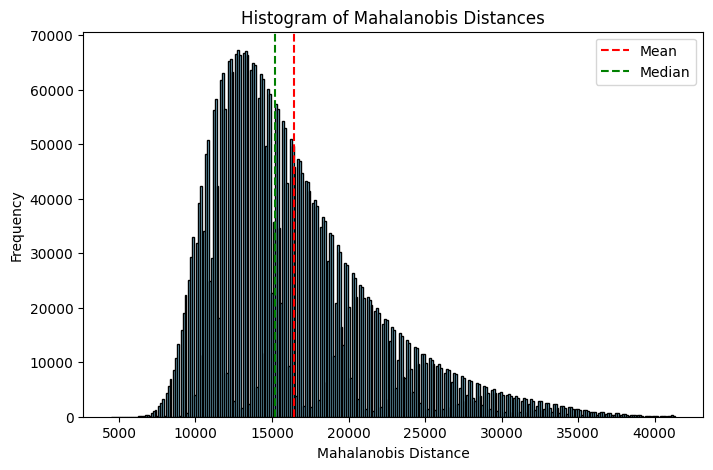

In [52]:
plt.figure(figsize=(8, 5))
plt.hist(mahal_distances, bins=300, color='skyblue', edgecolor='black')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis Distances")
plt.axvline(x=mean_val, color='red', linestyle='--', label='Mean')
plt.axvline(x=median_val, color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


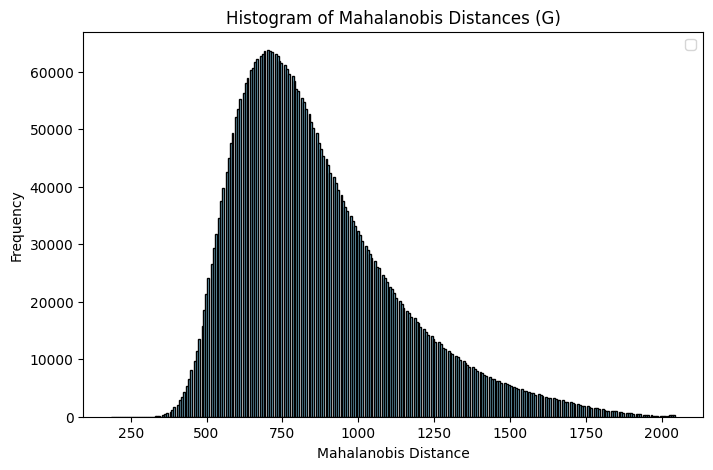

In [51]:
plt.figure(figsize=(8, 5))
plt.hist(mahal_distances_green, bins=300, color='skyblue', edgecolor='black')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis Distances (G)")
#plt.axvline(x=mean_val, color='red', linestyle='--', label='Mean')
#plt.axvline(x=median_val, color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

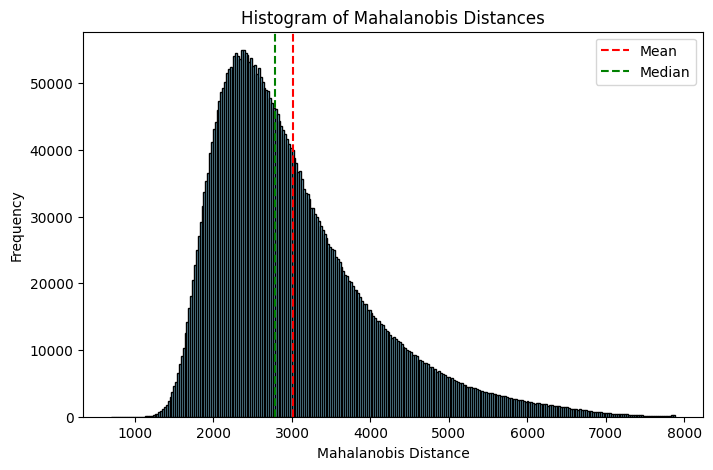

In [20]:
plt.figure(figsize=(8, 5))
plt.hist(mahal_distances_wood, bins=300, color='skyblue', edgecolor='black')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.title("Histogram of Mahalanobis Distances")
plt.axvline(x=mean_val_wood, color='red', linestyle='--', label='Mean')
plt.axvline(x=median_val_wood, color='green', linestyle='--', label='Median')
plt.legend()
plt.show()

In [21]:
threshold = 10000
grape_points_mask = mahal_distances <= threshold
grape_points_rgb = lidar_rgb[grape_points_mask]
print("Number of LiDAR points classified as grapes:", grape_points_rgb.shape[0])

Number of LiDAR points classified as grapes: 207478


In [23]:
dists = mahal_distances.reshape(-1, 1)
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(dists)
labels = gmm.predict(dists)
component_means = gmm.means_.flatten()
grape_component = np.argmin(component_means)
grape_points_mask = labels == grape_component
print("Number of points classified as grapes:", np.count_nonzero(grape_points_mask))

Number of points classified as grapes: 1551967


In [24]:
las.classification[grape_points_mask] = 1
num_grape_points = np.count_nonzero(las.classification == 1)
print("Number of points classified as grapes:", num_grape_points)

Number of points classified as grapes: 1551967


In [25]:
las.write('CodyKresta8_8_24_riesling_low1_ref_Row_3_classified.las')